In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from scipy.optimize import minimize

import pandas as pd
import exoplanet as xo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare

In [2]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

# Periodic light curve with flares
f1 = 'tess2019006130736-s0007-0000000294750180-0131-s_lc.fits'

# This one is breaking the gaussian process pipline
f2 = 'tess2019006130736-s0007-0000000011068680-0131-s_lc.fits'

# Flare star candidate that jim picked out
f3 = 'tess2019006130736-s0007-0000000458616184-0131-s_lc.fits'

# Lots of short period (~0.2 day) variations
# Smoothing starts to break if we downsample too much
f4 = 'tess2019006130736-s0007-0000000014498757-0131-s_lc.fits'

# Definitely some flares, lots of low level noise, but it kind of looks periodic? GP fit fails completely
f5 = 'tess2019006130736-s0007-0000000016053378-0131-s_lc.fits'

# Huge spike that doesnt look like a flare. Looks gaussian
f6 = 'tess2019006130736-s0007-0000000016159436-0131-s_lc.fits'

# Eclipsing binary, causes spurious flare detections
f7 = 'tess2019006130736-s0007-0000000019193162-0131-s_lc.fits'

# Flare at t=1505.13 goes undetected, gp smoothing isnt doing great here
f8 = 'tess2019006130736-s0007-0000000022970720-0131-s_lc.fits'

f9 = 'tess2019006130736-s0007-0000000026045729-0131-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

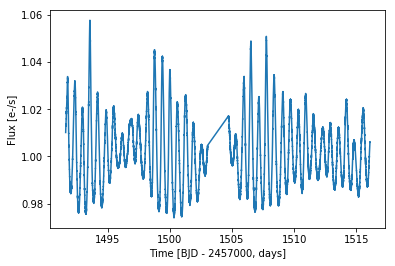

In [3]:
with fits.open(path+f9, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
mask = (tess_quality == 0) #& (tess_bjds < 1500)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.nanmedian(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

0.6451612903225806


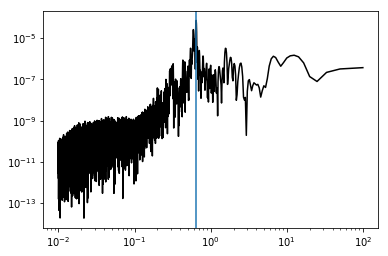

In [4]:
from astropy.stats import LombScargle

x = time
y = flux/median
yerr = error/median

freq = np.linspace(1e-2, 100.0, 10000)
model = LombScargle(x, y)
power = model.power(freq, method='fast', normalization='psd')
power /= len(x)
period = 1.0 / freq[np.argmax(power)]
print(period)

plt.plot(1.0 / freq, power, 'k')
plt.axvline(period)
plt.xscale('log')
plt.yscale('log')

0.6229036670256392


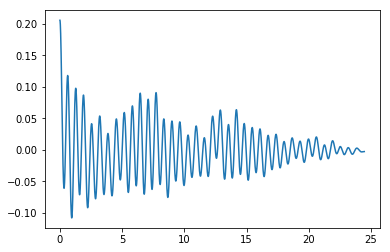

In [5]:
acf = xo.autocorr_estimator(x, y, yerr=yerr, min_period=0.1, max_period=27, max_peaks=2)
period = acf['peaks'][0]['period']
print(period)

plt.plot(acf['autocorr'][0], acf['autocorr'][1])

In [16]:
interval = 10

x = time[::interval]
y = flux[::interval]/median
yerr = error[::interval]/median

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-20, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 2*np.pi/period
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

kernel += terms.JitterTerm(log_sigma=np.log(np.median(yerr)),
                               bounds=[(-20.0, 5.0)])

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

# Lets try reweighting points rather than throwing them out
pen = 0.2 # penalty factor to apply to outliers

yerr_rw = np.copy(yerr)

for i in range(5):
    gp.compute(x, yerr_rw)
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(soln.x)
    initial_params = soln.x
    mu, var = gp.predict(y, x, return_var=True)
    sig = np.sqrt(var + yerr**2)
    
    chisq = (y - mu)**2/yerr**2
    yerr_rw = 1/np.sqrt(pen/(yerr**2*(chisq + pen)))
    
fit_x, fit_y, fit_yerr = x, y, yerr

gp.compute(fit_x, fit_yerr)
gp.log_likelihood(fit_y)   
gp.get_parameter_dict()

Initial log likelihood: 6116.113959275958


OrderedDict([('kernel:terms[0]:log_S0', -9.79943758721953),
             ('kernel:terms[0]:log_omega0', 1.7694564934426196),
             ('kernel:terms[1]:log_S0', -15.85512909255783),
             ('kernel:terms[1]:log_Q', -2.988432708609811),
             ('kernel:terms[1]:log_omega0', -3.9687103460664854),
             ('kernel:terms[2]:log_sigma', -16.166298330014616)])

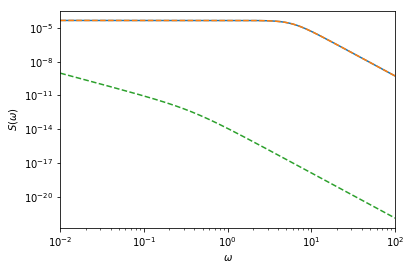

In [17]:
omega = np.exp(np.linspace(np.log(1e-2), np.log(100), 500))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

Text(0, 0.5, 'Flux [e-/s]')

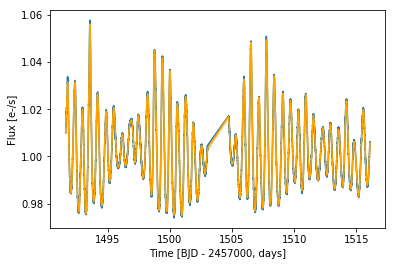

In [18]:
std = np.sqrt(var)

plt.plot(time, flux/median)
plt.plot(time[::interval], mu, color='orange')
plt.fill_between(time[::interval], mu+std*3, mu-std*3, color='orange', alpha=0.3, edgecolor='none')
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

[0.00556613]
1 flares found at t=[1507.73977624]


(1507.6, 1507.8)

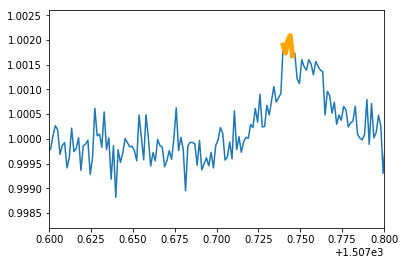

In [22]:
# Need to interpolate mu and sigma after downsampling
mu_interp = np.interp(time, time[::interval], mu)
plt.plot(time, (flux/median)-mu_interp+1)
#plt.xlim(1512.5, 1512.65)
#plt.ylim(0.98, 1.03)
start_i, stop_i = FINDflare((flux/median)-mu_interp, error, avg_std=True, std_window=1000, N1=4, N2=2, N3=5)
ed = np.zeros(len(start_i))
for idx in range(len(start_i)):
    i, j = start_i[idx], stop_i[idx]
    plt.plot(time[i:j], (flux[i:j]/median)-mu_interp[i:j]+1, lw=5, color='orange') 
    
    # equivalent duration
    x = time
    y = (flux/median) - mu_interp+1
    ed[idx] = np.trapz(y[i:j], x[i:j])
    
print(ed)

print(str(len(start_i)) + ' flares found at t=' + str(time[start_i]))

plt.xlim(1507.6, 1507.8)
#plt.xlim(1493, 1493.05)
#plt.ylim(0.99, 1.02)

27.17256005912667


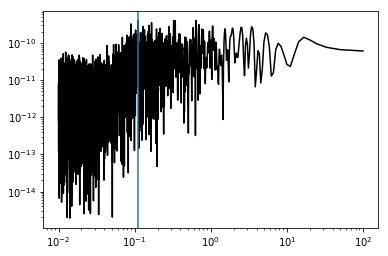

In [15]:
from astropy.stats import LombScargle

x = time
y = (flux/median)-mu_interp

freq = np.linspace(1e-2, 100.0, 10000)
model = LombScargle(x, y)
power = model.power(freq, method='fast', normalization='psd')
power /= len(x)
period = 1.0 / freq[np.argmax(power)]
print(np.max(power)/np.mean(power))

plt.plot(1.0 / freq, power, 'k')
plt.axvline(period)
plt.xscale('log')
plt.yscale('log')

Initial log likelihood: -4189.31321582677
      fun: 3118.8023432044706
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.54747351e-05, 4.54747351e-05, 1.93722371e-02, 1.14596332e-02,
       6.61202648e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 318
      nit: 37
   status: 0
  success: True
        x: array([  4.95259045, -10.12257017,   5.41514833,   0.45792591,
         2.8870418 ])
kernel:terms[0]:log_S0 4.952590445158123
kernel:terms[0]:log_omega0 -10.122570171255926
kernel:terms[1]:log_S0 5.415148328531895
kernel:terms[1]:log_Q 0.45792591373736696
kernel:terms[1]:log_omega0 2.8870418003842246


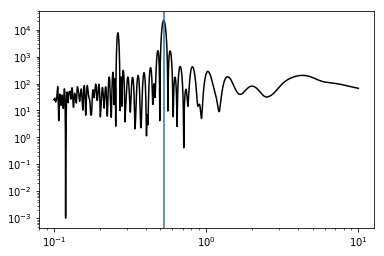

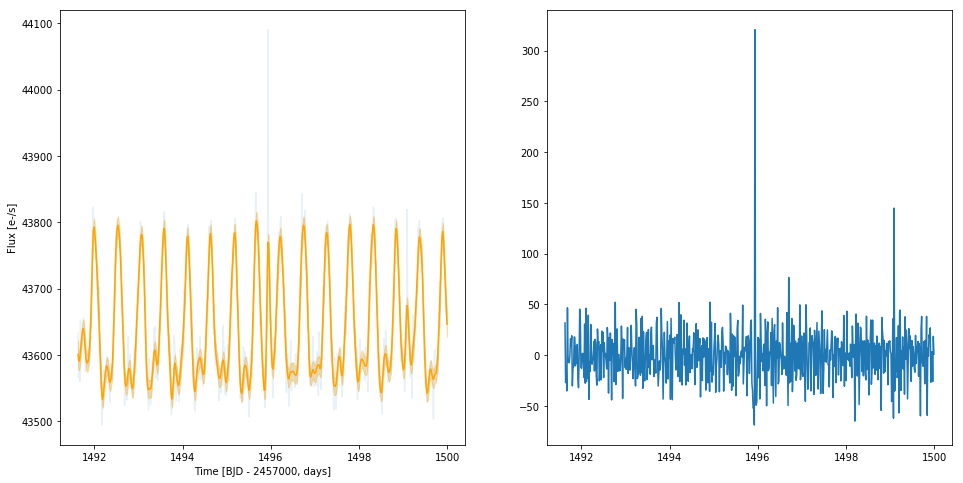

In [92]:
# Changing the sampling interval severely changes the best fit parameters for the periodic component
# Too sparse of an interval completely breaks the fit, whats going on?

interval = 10
x = time[::interval]
y = flux[::interval]
yerr = error[::interval]

freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(time, flux)
power = model.power(freq, method='fast', normalization='psd')
power /= len(x)
period = 1.0 / freq[np.argmax(power)]

plt.plot(1.0 / freq, power, 'k')
plt.axvline(period)
plt.xscale('log')
plt.yscale('log')

# Combination of simple harmonic oscillators (follows celerite tutorial)
Q = 1.0 / np.sqrt(2.0)
w0 = period
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)
    
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(x, y, alpha=0.1)
axes[0].plot(x, pred_mean, color='orange', zorder=3)
axes[0].fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='orange', alpha=0.3)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')
axes[1].plot(x, y-pred_mean)

From the celerite tutorial at<br>
<a href="https://celerite.readthedocs.io/en/stable/tutorials/first/">https://celerite.readthedocs.io/en/stable/tutorials/first/</a><br>

See <a href="https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.2094A">Angus 2017</a> for a discussion of using gaussian processes to model stellar rotation<br>

See section 4 of <a href="https://ui.adsabs.harvard.edu/abs/2018RNAAS...2a..31F">Foreman-Mackey 2018</a> for a discussion of the SHO kernel

(-2.5, 2.5)

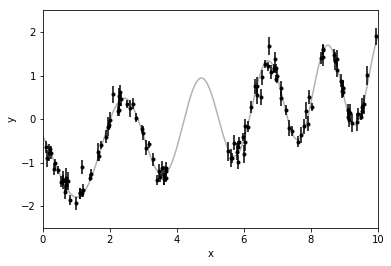

In [2]:
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)

In [3]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [4]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.75659638262951


In [5]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -0.8497786656258695), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -1.1963522559058422), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-0.84977867  1.09861229 -1.19635226  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



In [6]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -16.563201709211853
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.82121026e-05,  1.13686838e-05, -5.11590770e-05,  8.52651283e-06,
       -3.58113539e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 306
      nit: 30
   status: 0
  success: True
        x: array([ 3.2782789 , -2.02464554, -4.16135722,  2.34183996,  1.13554455])


In [7]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 3.278278897453691),
             ('kernel:terms[0]:log_omega0', -2.024645541229001),
             ('kernel:terms[1]:log_S0', -4.161357218844049),
             ('kernel:terms[1]:log_Q', 2.341839956047069),
             ('kernel:terms[1]:log_omega0', 1.1355445484482187)])

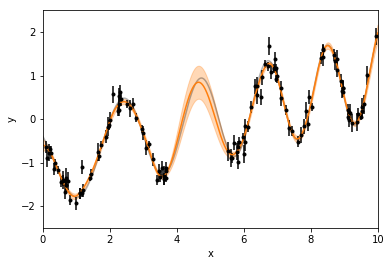

In [8]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

Try this with a TESS light curve

In [151]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

# Anomalous flares were being detected at the gap edges in this light curve when
# using rolling median subtraction
f1 = 'tess2019006130736-s0007-0000000059764377-0131-s_lc.fits'

# A nice smoothly varying periodic light curve
f2 = 'tess2019006130736-s0007-0000000349275562-0131-s_lc.fits'

# Periodic light curve with flares
f3 = 'tess2019006130736-s0007-0000000294750180-0131-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

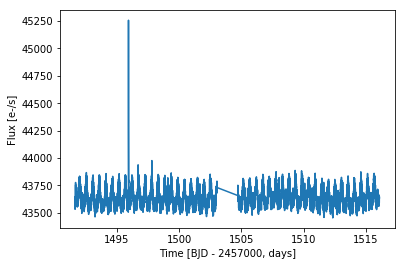

In [152]:
with fits.open(path+f3, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
# Throw out NaN fluxes
mask = tess_quality == 0
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

<ErrorbarContainer object of 3 artists>

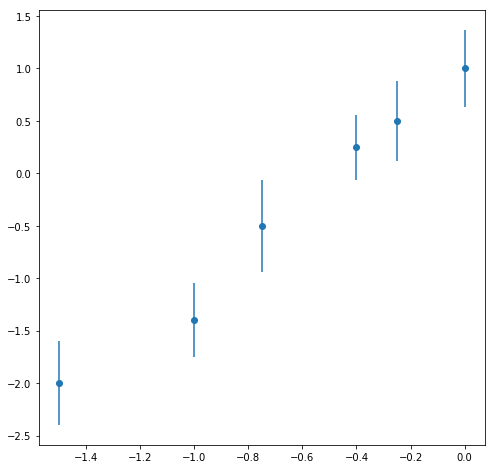

In [153]:
# Some simple made up data

xdata = [-1.5, -1, -0.75, -0.4, -0.25, 0]
ydata = [-2, -1.4, -0.5, 0.25, 0.5, 1]
ydataerr = [0.4, 0.35, 0.44, 0.31, 0.38, 0.37]

fig, axes = plt.subplots(figsize=(8,8))
axes.errorbar(xdata, ydata, yerr=ydataerr, fmt='o')

Play with squared exponential kernel

Initial log likelihood: -7.956822184586894
      fun: 7.141449776777412
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.88178420e-07,  1.50990331e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
   status: 0
  success: True
        x: array([ 0.35168795, -0.40683866])
kernel:log_a 0.3516879497165276
kernel:log_c -0.40683866202618235


Text(0, 0.5, 'Flux [e-/s]')

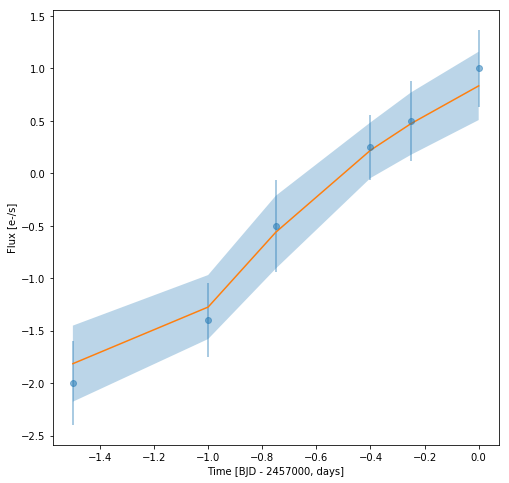

In [154]:
x = xdata
y = ydata
yerr = ydataerr

# k = a*exp(-c*tau)
a = 1 # Amplitude
c = 0.1 # Length scale
bounds = dict(log_a=(-15, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log10(a), log_c=np.log10(c), bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(8,8))
axes.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.5)
axes.plot(x, pred_mean)
axes.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, alpha=0.3)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

Initial log likelihood: -14306.630267459966
      fun: 8506.160163307279
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00181899,  0.0007276 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 7
   status: 0
  success: True
        x: array([8.7119496 , 1.82221956])
kernel:log_a 8.7119496005987
kernel:log_c 1.8222195629500997


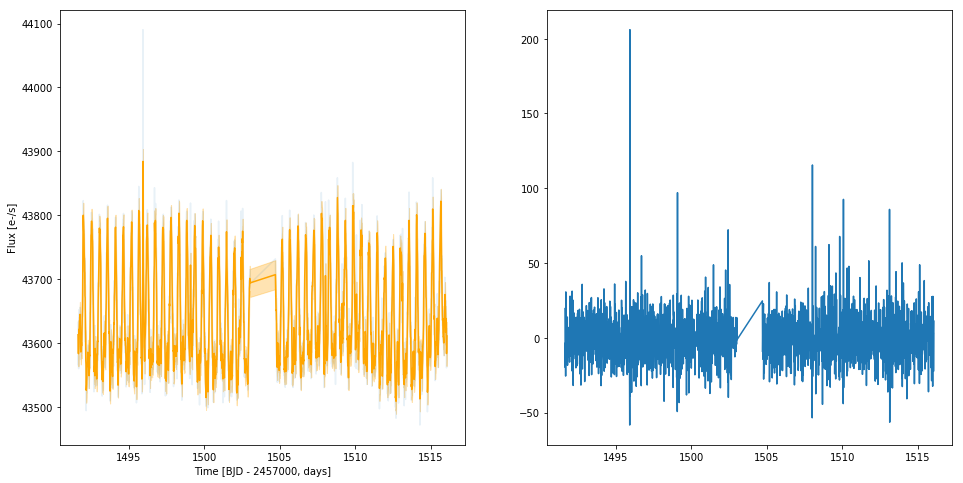

In [155]:
interval = 10
mask = time < 1696
x = time[mask][::interval]
y = flux[mask][::interval]
yerr = error[mask][::interval]

# k = a*exp(-c*tau)
a = 1 # Amplitude
c = 1 # Length scale
bounds = dict(log_a=(-15, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log10(a), log_c=np.log10(c), bounds=bounds)
#kernel.freeze_parameter('log_c')

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(x, y, alpha=0.1)
axes[0].plot(x, pred_mean, color='orange', zorder=3)
axes[0].fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='orange', alpha=0.3)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')
axes[1].plot(x, y-pred_mean)

Initial log likelihood: -9856.010203366193
      fun: 8398.143604765144
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00181899, 0.07112249, 0.00090949])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 136
      nit: 19
   status: 0
  success: True
        x: array([6.23004064, 2.7984921 , 2.3946195 ])
kernel:terms[0]:log_S0 6.230040640465918
kernel:terms[0]:log_omega0 2.798492098623005
kernel:terms[1]:log_sigma 2.394619496656588


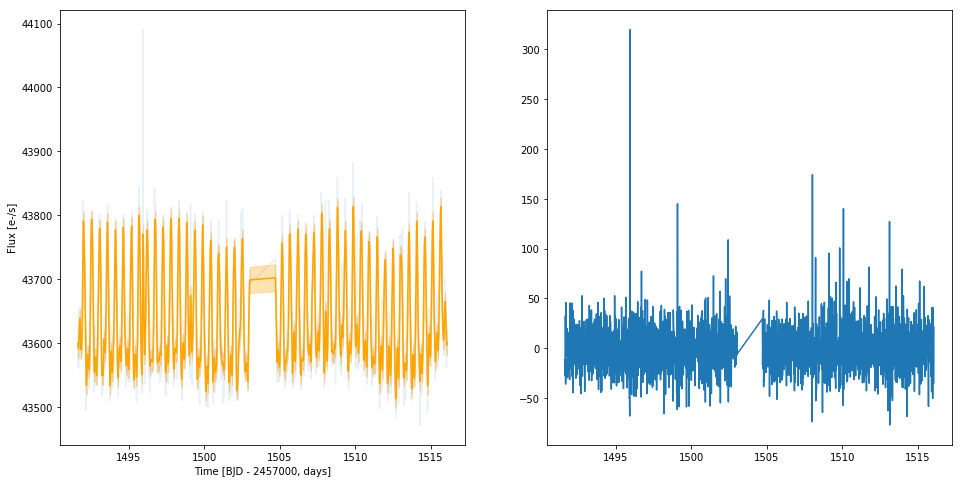

In [156]:
# Changing the sampling interval here changes the fit parameters for the kernel, but not as badly
# as for the two SHOs

interval = 10
x = time[::interval]
y = flux[::interval]
yerr = error[::interval]

# Simple harmonic oscillator kernel
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# Jitter term
kernel += terms.JitterTerm(log_sigma=np.log(np.median(yerr)),
                           bounds=[(-20.0, 5.0)])

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(x, y, alpha=0.1)
axes[0].plot(x, pred_mean, color='orange', zorder=3)
axes[0].fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='orange', alpha=0.3)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')
axes[1].plot(x, y-pred_mean)

Plot up the SHO kernel<br>

This comes from the differential equation for a stochastically driven damped harmonic oscillator which has the form<br>

m$\ddot{x}$ + $\gamma \dot{x}$ + kx = F(t)

m is the mass, k is the spring constant and $\gamma$ is the drag coefficient

The solution to this has the power spectrum

$S(\omega)$ = $\sqrt{\frac{2}{\pi}} \frac{S_0 \omega_{0}^4}{(\omega^2 - \omega_{0}^2)^2 + \omega_{0}^2 \omega^2/Q^2}$

where $\omega_0 = \sqrt{k/m}$ is the resonant frequency and Q = m/$\gamma$ is the drag-acceleration coefficient.

Text(0, 0.5, 'S($\\omega$)')

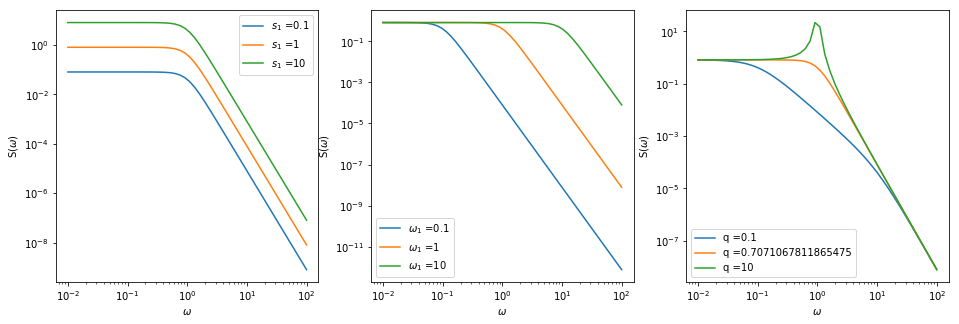

In [157]:
def s(omega, s1, omega1, q):
    a = s1*omega1**4
    b = (omega**2 - omega1**2)**2 + omega1**2*omega**2/q**2
    return np.sqrt(2/np.pi)*a/b

omega_vals = np.logspace(-2, 2)
omega1_vals = [0.1, 1, 10]
s1_vals = [0.1, 1, 10]
q_vals = [0.1, 1/np.sqrt(2), 10]
default_idx = 1

fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=3)
for s1_val in s1_vals:
    s_vals = s(omega_vals, s1_val, omega1_vals[default_idx], q_vals[default_idx])
    axes[0].loglog(omega_vals, s_vals, label=r'$s_{1}$ =' + str(s1_val))
axes[0].legend()
axes[0].set_xlabel(r'$\omega$')
axes[0].set_ylabel(r'S($\omega$)')

for omega1_val in omega1_vals:
    s_vals = s(omega_vals, s1_vals[default_idx], omega1_val, q_vals[default_idx])
    axes[1].loglog(omega_vals, s_vals, label=r'$\omega_{1}$ =' + str(omega1_val))
axes[1].legend()
axes[1].set_xlabel(r'$\omega$')
axes[1].set_ylabel(r'S($\omega$)')

for q_val in q_vals:
    s_vals = s(omega_vals, s1_vals[default_idx], omega1_vals[default_idx], q_val)
    axes[2].loglog(omega_vals, s_vals, label='q =' + str(q_val))
axes[2].legend()
axes[2].set_xlabel(r'$\omega$')
axes[2].set_ylabel(r'S($\omega$)')

Initial log likelihood: -92266.9323083776
kernel:terms[0]:log_S0 6.2556385315157375
kernel:terms[0]:log_omega0 2.7759362482539043
kernel:terms[1]:log_S0 1.0215323921114794
kernel:terms[1]:log_Q -0.6456494763392012
kernel:terms[1]:log_omega0 5.839540061952582


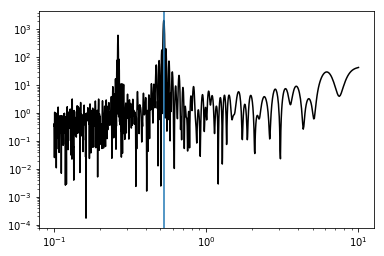

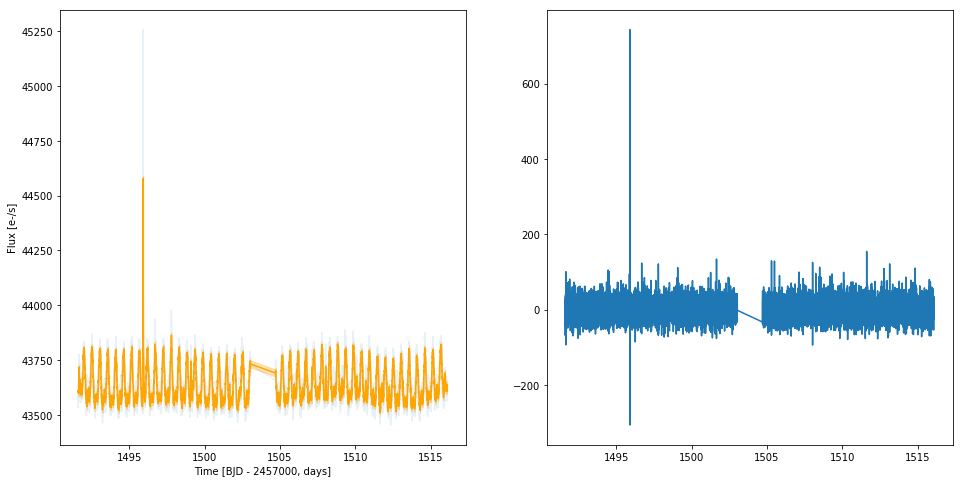

In [158]:
# Changing the sampling interval severely changes the best fit parameters for the periodic component
# Too sparse of an interval completely breaks the fit, whats going on?

interval = 1
mask = time < 1600
x = time[mask][::interval]
y = flux[mask][::interval]
yerr = error[mask][::interval]

freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(x, y)
power = model.power(freq, method='fast', normalization='psd')
power /= len(x)
period = 1.0 / freq[np.argmax(power)]

plt.plot(1.0 / freq, power, 'k')
plt.axvline(period)
plt.xscale('log')
plt.yscale('log')

# Combination of simple harmonic oscillators (follows celerite tutorial)
Q = 1.0 / np.sqrt(2.0)
w0 = period
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)
    
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(x, y, alpha=0.1)
axes[0].plot(x, pred_mean, color='orange', zorder=3)
axes[0].fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='orange', alpha=0.3)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')
axes[1].plot(x, y-pred_mean)

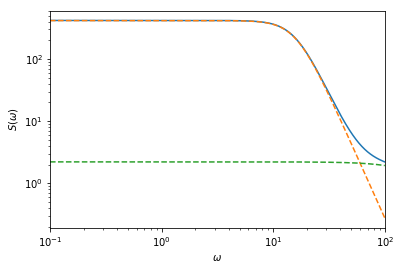

In [159]:
omega = np.exp(np.linspace(np.log(0.1), np.log(100), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [160]:
class MixtureOfSHOsTerm(terms.SHOTerm):
    parameter_names = ("log_a", "log_Q1", "mix_par", "log_Q2", "log_P")

    def get_real_coefficients(self, params):
        return np.empty(0), np.empty(0)

    def get_complex_coefficients(self, params):
        log_a, log_Q1, mix_par, log_Q2, log_period = params

        Q = np.exp(log_Q2) + np.exp(log_Q1)
        log_Q1 = np.log(Q)
        P = np.exp(log_period)
        log_omega1 = np.log(4*np.pi*Q) - np.log(P) - 0.5*np.log(4.0*Q*Q-1.0)
        log_S1 = log_a - log_omega1 - log_Q1

        mix = -np.log(1.0 + np.exp(-mix_par))
        Q = np.exp(log_Q2)
        P = 0.5*np.exp(log_period)
        log_omega2 = np.log(4*np.pi*Q) - np.log(P) - 0.5*np.log(4.0*Q*Q-1.0)
        log_S2 = mix + log_a - log_omega2 - log_Q2

        c1 = super(MixtureOfSHOsTerm, self).get_complex_coefficients([
            log_S1, log_Q1, log_omega1,
        ])

        c2 = super(MixtureOfSHOsTerm, self).get_complex_coefficients([
            log_S2, log_Q2, log_omega2,
        ])

        return [np.array([a, b]) for a, b in zip(c1, c2)]

    def log_prior(self):
        lp = super(MixtureOfSHOsTerm, self).log_prior()
        if not np.isfinite(lp):
            return -np.inf
        mix = 1.0 / (1.0 + np.exp(-self.mix_par))
        return lp + np.log(mix) + np.log(1.0 - mix)

Initial log likelihood: -82032.69556179152
      fun: 81119.66182367258
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.82076609e-03,  8.73114914e-03,  7.27595761e-03,  9.26957000e-01,
        2.82307155e-01, -7.85803422e-02, -8.73114914e-03,  5.80327469e+02,
        4.20550350e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 790
      nit: 45
   status: 0
  success: True
        x: array([ 5.9740726 , -4.67325036, -2.54414957,  2.62855101,  8.74076645,
       11.        ,  4.9292804 , -0.34657359, -0.64341805])
kernel:terms[0]:log_S0 5.974072603984237
kernel:terms[0]:log_Q -4.673250360304806
kernel:terms[0]:log_omega0 -2.5441495682645363
kernel:terms[1]:log_sigma 2.628551008793199
kernel:terms[2]:log_a 8.74076644777804
kernel:terms[2]:log_Q1 11.0
kernel:terms[2]:mix_par 4.929280400102679
kernel:terms[2]:log_Q2 -0.34657359027997264
kernel:terms[2]:log_P -0.6434180548812211


Text(0, 0.5, 'Flux [e-/s]')

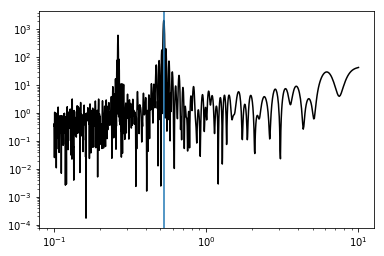

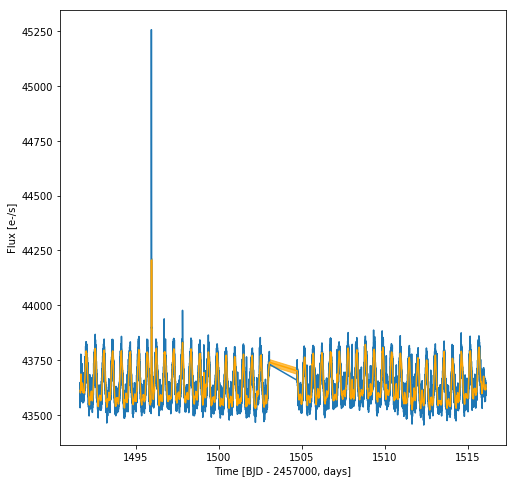

In [174]:
from astropy.stats import LombScargle

interval = 1
x = time[::interval]
y = flux[::interval]
yerr = error[::interval]

freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(x, y)
power = model.power(freq, method='fast', normalization='psd')
power /= len(x)
period = 1.0 / freq[np.argmax(power)]

min_period = period * 0.7
max_period = period / 0.7

plt.plot(1.0 / freq, power, 'k')
plt.axvline(period)
plt.xscale('log')
plt.yscale('log')

# Flareninja rotation kernel

kernel = terms.SHOTerm(
        log_S0=np.log(np.var(y)),
        log_Q=-np.log(4.0),
        log_omega0=np.log(2*np.pi/10.),
        bounds=dict(
            log_S0=(-20.0, 10.0),
            log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
        ),)

# Jitter term
kernel += terms.JitterTerm(log_sigma=np.log(np.median(yerr)),
                           bounds=[(-20.0, 5.0)])

# Mixture of SHO terms? Not sure this is right yet

kernel += MixtureOfSHOsTerm(
        log_a=np.log(np.var(y)),
        log_Q1=np.log(15),
        mix_par=-1.0,
        log_Q2=np.log(15),
        log_P=np.log(period),
        bounds=dict(
            log_a=(-20.0, 10.0),
            log_Q1=(-0.5*np.log(2.0), 11.0),
            mix_par=(-5.0, 5.0),
            log_Q2=(-0.5*np.log(2.0), 11.0),
            log_P=(np.log(min_period), np.log(max_period)),
        ))

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)
axes.plot(x, pred_mean, color='orange', zorder=3)
axes.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, alpha=0.7, color='orange')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

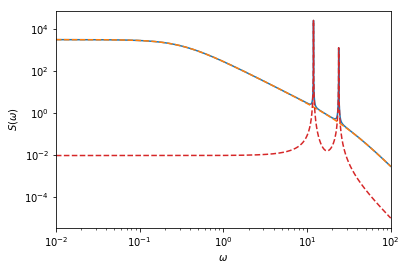

In [167]:
omega = np.exp(np.linspace(np.log(0.01), np.log(100), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

Text(0, 0.5, 'Flux [e-/s]')

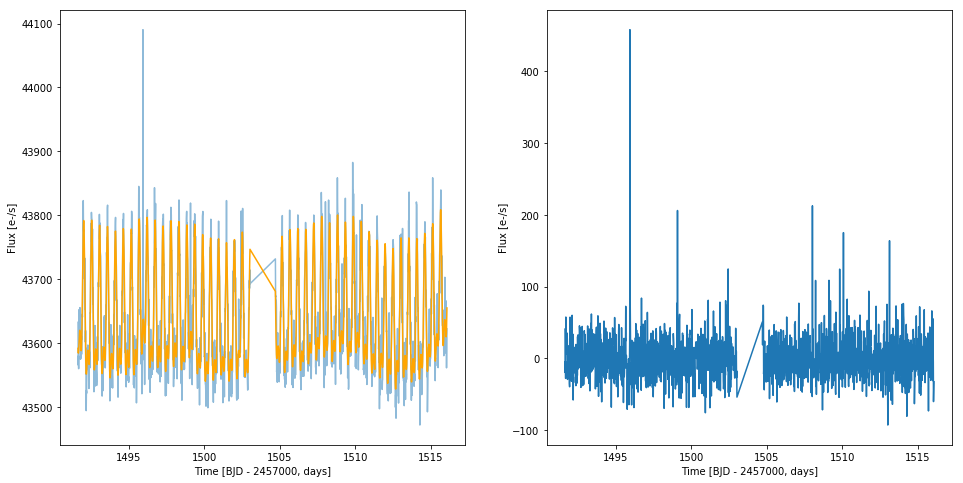

In [172]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(x, y, alpha=0.5)
axes[0].plot(x, pred_mean, color='orange', zorder=3)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

axes[1].plot(x, y-pred_mean)
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux [e-/s]')

In [173]:
# Need to interpolate pred_mean to subtract it from flux
start_i, stop_i = FINDflare(flux-pred_mean, error, avg_std=False, N1=4, N2=2, N3=5)
print(str(len(start_i)) + ' flares found at t=' + str(time[start_i]))

ValueError: operands could not be broadcast together with shapes (16356,) (1636,) 

Text(0, 0.5, 'Flux [e-/s]')

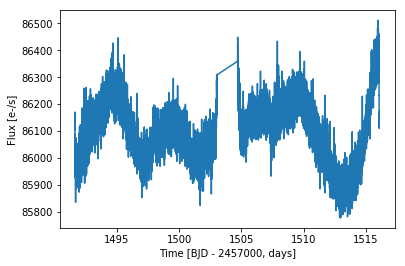

In [176]:
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
# Throw out NaN fluxes
mask = tess_quality == 0
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

Initial log likelihood: -85052.44846445836
      fun: 83639.45269479232
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.20489858e+01, -1.16415322e-02, -5.13609848e+01, -1.89174898e-02,
       -4.80213203e-02, -1.30967237e-02, -2.32830644e-02,  4.63362085e+01,
        1.46930688e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 680
      nit: 55
   status: 0
  success: True
        x: array([10.        , -1.67613076,  1.14472989,  2.8445323 ,  9.31292097,
        2.93971336,  5.        , -0.34657359,  1.30871011])
kernel:terms[0]:log_S0 10.0
kernel:terms[0]:log_Q -1.6761307613542287
kernel:terms[0]:log_omega0 1.1447298858494002
kernel:terms[1]:log_sigma 2.844532304438266
kernel:terms[2]:log_a 9.312920970200224
kernel:terms[2]:log_Q1 2.939713357666321
kernel:terms[2]:mix_par 5.0
kernel:terms[2]:log_Q2 -0.34657359027997264
kernel:terms[2]:log_P 1.3087101091157018


Text(0, 0.5, 'Flux [e-/s]')

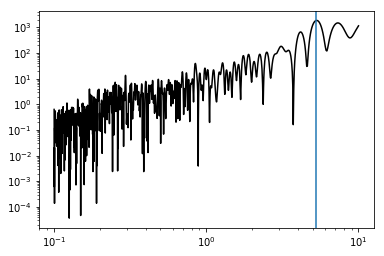

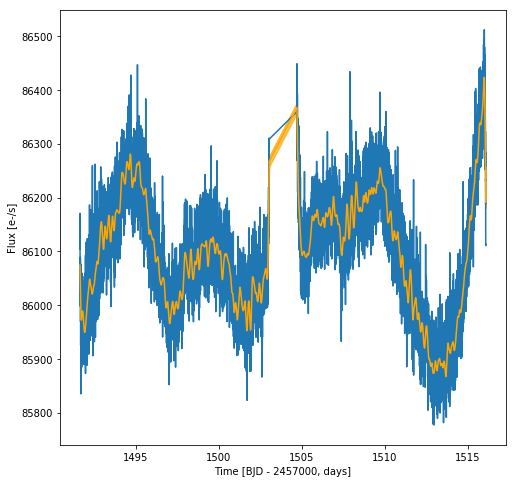

In [177]:
from astropy.stats import LombScargle

interval = 1
x = time[::interval]
y = flux[::interval]
yerr = error[::interval]

freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(x, y)
power = model.power(freq, method='fast', normalization='psd')
power /= len(x)
period = 1.0 / freq[np.argmax(power)]

min_period = period * 0.7
max_period = period / 0.7

plt.plot(1.0 / freq, power, 'k')
plt.axvline(period)
plt.xscale('log')
plt.yscale('log')

# Flareninja rotation kernel

kernel = terms.SHOTerm(
        log_S0=np.log(np.var(y)),
        log_Q=-np.log(4.0),
        log_omega0=np.log(2*np.pi/10.),
        bounds=dict(
            log_S0=(-20.0, 10.0),
            log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
        ),)

# Jitter term
kernel += terms.JitterTerm(log_sigma=np.log(np.median(yerr)),
                           bounds=[(-20.0, 5.0)])

# Mixture of SHO terms? Not sure this is right yet

kernel += MixtureOfSHOsTerm(
        log_a=np.log(np.var(y)),
        log_Q1=np.log(15),
        mix_par=-1.0,
        log_Q2=np.log(15),
        log_P=np.log(period),
        bounds=dict(
            log_a=(-20.0, 10.0),
            log_Q1=(-0.5*np.log(2.0), 11.0),
            mix_par=(-5.0, 5.0),
            log_Q2=(-0.5*np.log(2.0), 11.0),
            log_P=(np.log(min_period), np.log(max_period)),
        ))

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)
axes.plot(x, pred_mean, color='orange', zorder=3)
axes.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, alpha=0.7, color='orange')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')